# U-net model implementation 
This is an implementation of the U-Net model [from https://arxiv.org/abs/1505.04597v1](https://arxiv.org/abs/1505.04597v1) using the tensorflow API. \
The aim of the model implementation is to produce segmentation mask. \
Below is an example of the segmentation mask produced by the model compared to the true mask and the input image.



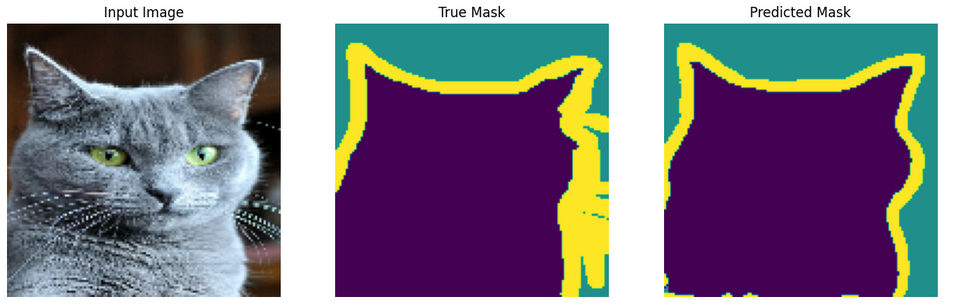

## Load and prepare dataset
The dataset part is highly inspired from the [tensorflow segmentation documentation](https://www.tensorflow.org/tutorials/images/segmentation).


The model is trained on the [oxford_iiit_pet](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet) dataset. 
The train data are images of cats and dogs and the labels consists of segmentation mask over the animal with a contour.

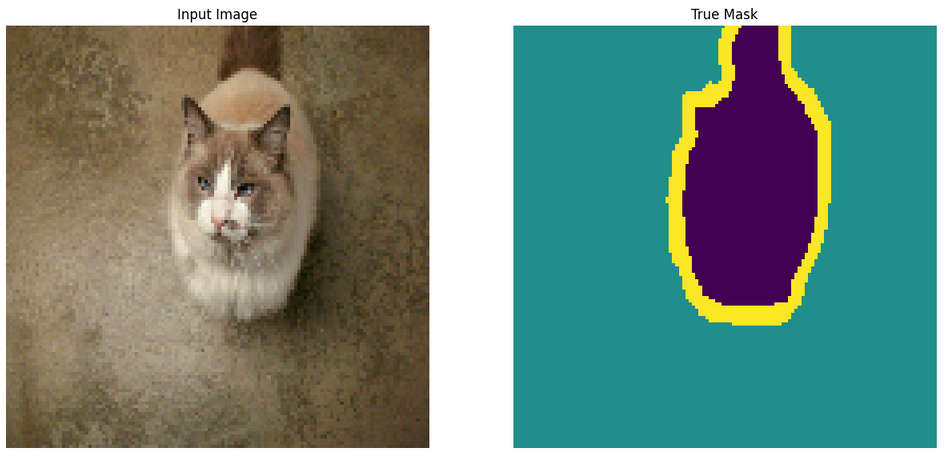

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [4]:
# Downloading dataset, see here for more info https://www.tensorflow.org/tutorials/images/segmentation
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, download=False)


2024-02-28 13:51:52.405053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 13:51:52.442377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 13:51:52.442753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
INPUT_SIZE=(128, 128)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


### Normalize and resize data

In [6]:
# Normalize input and update mask value 
""" according to the tensorflow website: he pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 
from the segmentation mask, resulting in labels that are : {0, 1, 2}."""

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], INPUT_SIZE)
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    INPUT_SIZE,
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

### Prepare train and test datasets with data augmentation

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


### Dataset preview

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


2024-02-28 13:51:54.321030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]
2024-02-28 13:51:54.321574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


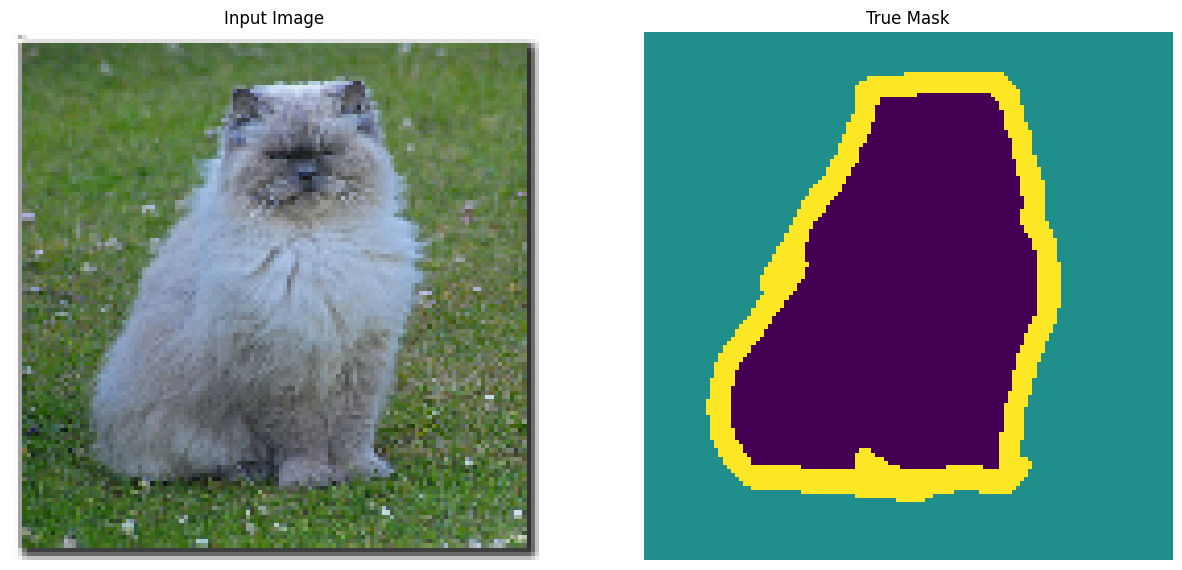

2024-02-28 13:51:54.976970: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


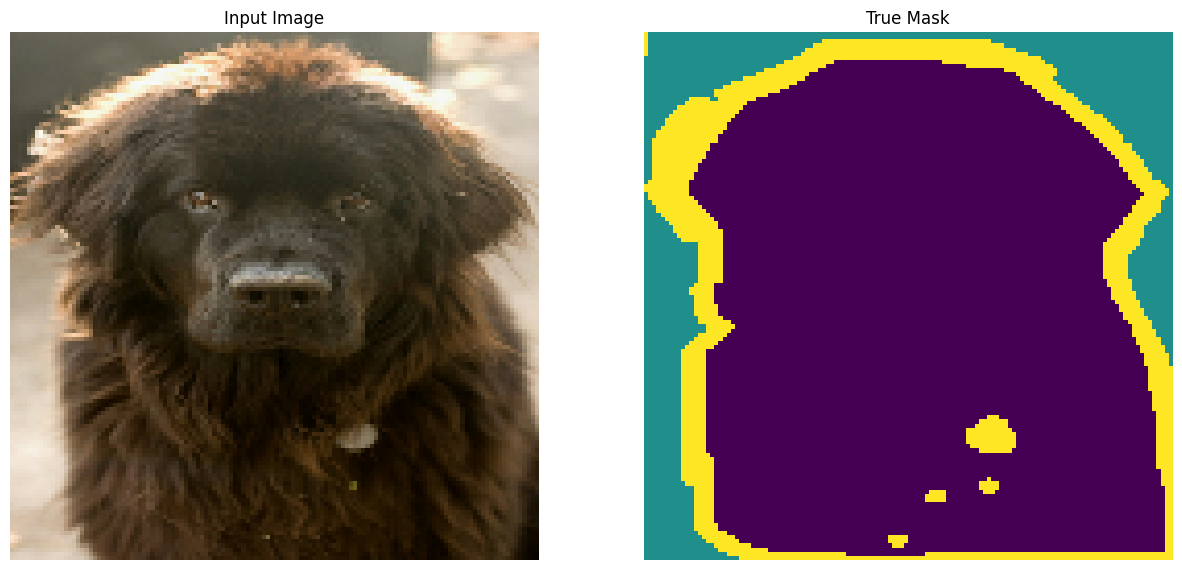

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


## U-net model
### Implementation of the model

In [14]:
# Model creation
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D
input_size = (128,128,3)
inputs = tf.keras.layers.Input(shape=INPUT_SIZE + (3,))
## DownSampling
# First conv
conv_1_1_down = Conv2D(filters=64, kernel_size=3, padding="same",activation="relu")(inputs)
conv_1_2_down = Conv2D(filters=64, kernel_size=3, padding="same",activation="relu")(conv_1_1_down)
max_pool_1 = MaxPooling2D(pool_size=(2, 2),strides=2,padding='same')(conv_1_2_down) 

# second conv
conv_2_1_down = Conv2D(filters=128, kernel_size=3, padding="same",activation="relu")(max_pool_1)
conv_2_2_down = Conv2D(filters=128, kernel_size=3, padding="same",activation="relu")(conv_2_1_down)
max_pool_2 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv_2_2_down) 

# thrid conv
conv_3_1_down = Conv2D(filters=256, kernel_size=3, padding="same",activation="relu")(max_pool_2)
conv_3_2_down = Conv2D(filters=256, kernel_size=3, padding="same",activation="relu")(conv_3_1_down)
max_pool_3 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv_3_2_down) 

# fourth conv
conv_4_1_down = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",activation="relu")(max_pool_3)
conv_4_2_down = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",activation="relu")(conv_4_1_down)
max_pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(conv_4_2_down) 

# fifth conv
conv_5_1_down = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, padding="same",activation="relu")(max_pool_4)
conv_5_2_down = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, padding="same",activation="relu")(conv_5_1_down)


##################
## UpSampling

#first up conv
up_sample_1_1 = UpSampling2D(size=(2, 2))(conv_5_2_down)
conv_1_1_up = tf.keras.layers.Conv2D(filters=512, kernel_size=2, padding="same",activation="relu")(up_sample_1_1)
concat_1_1_up = tf.keras.layers.Concatenate(axis=3)([conv_4_2_down, conv_1_1_up])
conv_1_2_up = tf.keras.layers.Conv2D(filters=512, kernel_size=2, padding="same",activation="relu")(concat_1_1_up)


#second up conv
up_sample_2_1 = UpSampling2D(size=(2, 2))(conv_1_2_up)
conv_2_1_up = tf.keras.layers.Conv2D(filters=256, kernel_size=2, padding="same",activation="relu")(up_sample_2_1)
concat_2_up = tf.keras.layers.Concatenate(axis=3)([conv_3_2_down, conv_2_1_up])
conv_2_2_up = tf.keras.layers.Conv2D(filters=256, kernel_size=2, padding="same",activation="relu")(concat_2_up)

#third up conv
up_sample_3_1 = UpSampling2D(size=(2, 2))(conv_2_2_up)
conv_3_1_up = tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding="same",activation="relu")(up_sample_3_1)
concat_3_up = tf.keras.layers.Concatenate(axis=3)([conv_2_2_down, conv_3_1_up])
conv_3_2_up = tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding="same",activation="relu")(concat_3_up)

#fourth up conv
up_sample_4_1 = UpSampling2D(size=(2, 2))(conv_3_2_up)
conv_4_1_up = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding="same",activation="relu")(up_sample_4_1)
concat_4_up = tf.keras.layers.Concatenate(axis=3)([conv_1_2_down, conv_4_1_up])
conv_4_2_up = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding="same",activation="relu")(concat_4_up)

conv_4_3_up = tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding="same",activation="softmax")(conv_4_2_up)

model = tf.keras.Model(inputs=inputs, outputs=conv_4_3_up)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)


Epoch 1/20


2024-02-28 13:51:55.385209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2024-02-28 13:51:55.385733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2024-02-28 13:51:59.734118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2024-02-28 13:52:02.576295: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x

57/57 [==============================] - ETA: 0s - loss: 0.9508 - accuracy: 0.5718

2024-02-28 13:52:23.330865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [4]
	 [[{{node Placeholder/_1}}]]
2024-02-28 13:52:23.331279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]


57/57 [==============================] - 29s 278ms/step - loss: 0.9508 - accuracy: 0.5718 - val_loss: 0.9316 - val_accuracy: 0.6099
Epoch 2/20
57/57 [==============================] - 18s 271ms/step - loss: 0.7938 - accuracy: 0.6735 - val_loss: 0.7265 - val_accuracy: 0.7047
Epoch 3/20
57/57 [==============================] - 15s 268ms/step - loss: 0.6919 - accuracy: 0.7186 - val_loss: 0.6734 - val_accuracy: 0.7242
Epoch 4/20
57/57 [==============================] - 15s 268ms/step - loss: 0.6431 - accuracy: 0.7391 - val_loss: 0.6383 - val_accuracy: 0.7421
Epoch 5/20
57/57 [==============================] - 15s 269ms/step - loss: 0.5711 - accuracy: 0.7731 - val_loss: 0.5432 - val_accuracy: 0.7829
Epoch 6/20
57/57 [==============================] - 15s 269ms/step - loss: 0.5252 - accuracy: 0.7925 - val_loss: 0.4845 - val_accuracy: 0.8117
Epoch 7/20
57/57 [==============================] - 15s 268ms/step - loss: 0.4767 - accuracy: 0.8138 - val_loss: 0.4757 - val_accuracy: 0.8119
Epoch 8/20

### Evaluate model on full test sample

In [17]:
model.evaluate(test_batches)

58/58 [==============================] - 6s 95ms/step - loss: 0.3338 - accuracy: 0.8760


[0.3337508738040924, 0.8759875297546387]

### Plot training and validation loss and accuracy

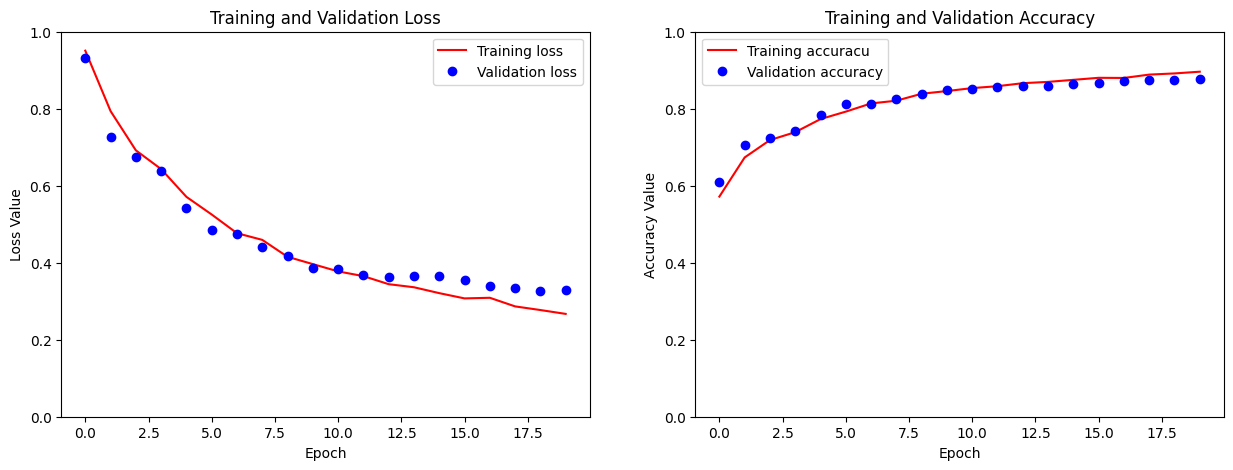

In [33]:

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(model_history.epoch, accuracy, 'r', label='Training accuracu')
plt.plot(model_history.epoch, val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()

plt.show()



### Preview some of the model predictions

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

1/1 [==============================] - 0s 21ms/step


2024-02-28 14:07:32.116949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]
2024-02-28 14:07:32.117513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_35' with dtype resource
	 [[{{node Placeholder/_35}}]]


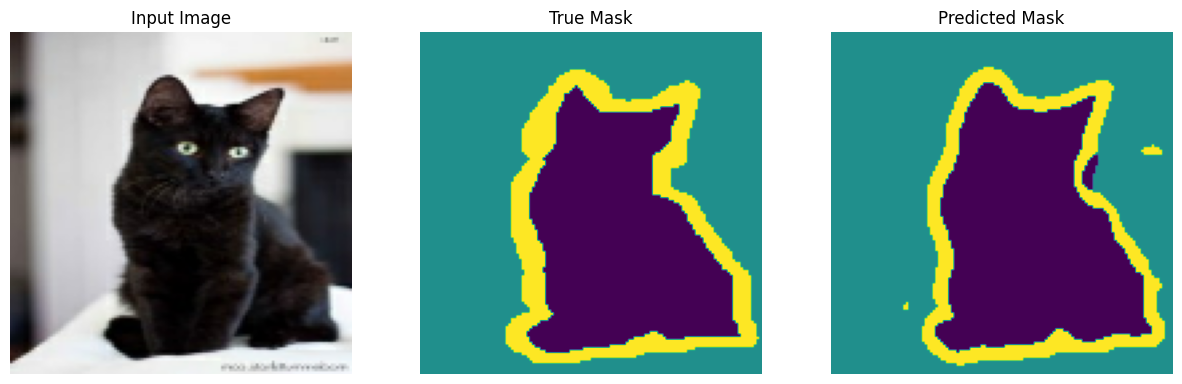

In [34]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]

  image_exp = tf.expand_dims(sample_image, axis=0)

  pred_mask = model.predict(image_exp)[0]

  display([sample_image, sample_mask, create_mask(pred_mask)])

### Furter work
* Improve model performances
* Reduce overfitting